In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc

In [2]:
# Read Data

training_data_df = pd.read_csv('./prepped_data/training_data_ver_4.csv')
print(training_data_df.shape)
training_data_df.head()

(4395795, 26)


,지번주소,도로명주소,trade_type,전용면적(㎡),금액(만원),월세(만원),가격/면적,층,건물나이,target_log_transformed,target/area_log_transformed,특수지구분명,공시지가,표준지여부,지목코드,토지면적,용도지역코드1,용도지역코드2,지형높이코드,지형형상코드,도로접면코드,year_linear,month_sin,month_cos,si_mapped,dong_mapped
0,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,7.666667,-0.866025,-0.500000,0,0
1,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,7.916667,-0.500000,0.866025,0,0
2,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,35000,0,450.160772,4,25,10.463103,6.109605,1,9210000,0,8,1168.3,15,0,2,3,3,7.000000,0.000000,1.000000,0,0
3,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,32000,0,411.575563,9,25,10.373491,6.019993,1,9210000,0,8,1168.3,15,0,2,3,3,7.166667,0.866025,0.500000,0,0
4,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,37000,0,475.884244,1,25,10.518673,6.165175,1,9210000,0,8,1168.3,15,0,2,3,3,7.666667,-0.866025,-0.500000,0,0


In [6]:
no_monthly_pay_df = training_data_df[(training_data_df['trade_type']!=2)&(training_data_df['trade_type']!=5)&(training_data_df['trade_type']!=8)].reset_index(drop=True)
print(no_monthly_pay_df.shape)
no_monthly_pay_df.head()

(3593057, 26)


,지번주소,도로명주소,trade_type,전용면적(㎡),금액(만원),월세(만원),가격/면적,층,건물나이,target_log_transformed,target/area_log_transformed,특수지구분명,공시지가,표준지여부,지목코드,토지면적,용도지역코드1,용도지역코드2,지형높이코드,지형형상코드,도로접면코드,year_linear,month_sin,month_cos,si_mapped,dong_mapped
0,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,7.666667,-0.866025,-0.500000,0,0
1,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,7.916667,-0.500000,0.866025,0,0
2,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,35000,0,450.160772,4,25,10.463103,6.109605,1,9210000,0,8,1168.3,15,0,2,3,3,7.000000,0.000000,1.000000,0,0
3,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,32000,0,411.575563,9,25,10.373491,6.019993,1,9210000,0,8,1168.3,15,0,2,3,3,7.166667,0.866025,0.500000,0,0
4,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,37000,0,475.884244,1,25,10.518673,6.165175,1,9210000,0,8,1168.3,15,0,2,3,3,7.666667,-0.866025,-0.500000,0,0


In [7]:
no_monthly_pay_df = no_monthly_pay_df.drop(columns=['월세(만원)'])

In [8]:
no_monthly_pay_df['토지면적'] = no_monthly_pay_df['토지면적'].apply(np.log)
no_monthly_pay_df.rename(columns={'토지면적':'토지면적_log'}, inplace=True)

In [9]:
no_monthly_pay_df.drop(columns=['지번주소', '도로명주소'], inplace=True)

In [10]:
no_monthly_pay_df['공시지가'] = no_monthly_pay_df['공시지가'] / 10000
no_monthly_pay_df.rename(columns={'공시지가':'공시지가(만원)'}, inplace=True)

In [11]:
cat_cols = ['trade_type', '특수지구분명', '표준지여부', '지목코드', '용도지역코드1', '용도지역코드2', '지형높이코드',
            '지형형상코드', '도로접면코드', 'si_mapped', 'dong_mapped'
           ]

In [12]:
test_data = no_monthly_pay_df.sample(frac=0.2)
train_data = no_monthly_pay_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

(718611, 23)
(574889, 23)
(2299557, 23)


In [13]:
target_cols = ['금액(만원)', '가격/면적', 'target_log_transformed', 'target/area_log_transformed']#, 'land_area_log']

In [14]:
x_test = test_data.drop(columns=target_cols)
y_test = test_data['가격/면적']
print(x_test.shape)
print(y_test.shape)

(718611, 19)
(718611,)


In [15]:
x_valid = valid_data.drop(columns=target_cols)
y_valid = valid_data['가격/면적']
print(x_valid.shape)
print(y_valid.shape)

(574889, 19)
(574889,)


In [16]:
x_train = train_data.drop(columns=target_cols)
y_train = train_data['가격/면적']
print(x_train.shape)
print(y_train.shape)

(2299557, 19)
(2299557,)


<AxesSubplot:>

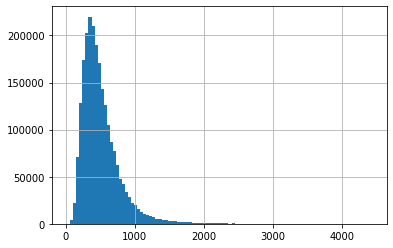

In [17]:
y_train.hist(bins=100)

# Training

In [18]:
from sklearn.metrics import r2_score

# ML Models

# Light GBM

In [19]:
import lightgbm as lgb

In [20]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'num_leaves': 31,
    'seed': 42,
    'max_depth': -1,
    'lambda_l2':0,
    'metric':'rmse'
}

In [21]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols)

In [22]:
# without 토지면적 log
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=100, verbose_eval=50)

c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 2299557, number of used features: 19


c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 509.619633
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 145.823
[100]	valid_0's rmse: 115.594
[150]	valid_0's rmse: 103.743
[200]	valid_0's rmse: 97.6233
[250]	valid_0's rmse: 94.0718
[300]	valid_0's rmse: 91.4622
[350]	valid_0's rmse: 89.4084
[400]	valid_0's rmse: 87.7282
[450]	valid_0's rmse: 86.3646
[500]	valid_0's rmse: 85.1912
[550]	valid_0's rmse: 84.0895
[600]	valid_0's rmse: 83.1018
[650]	valid_0's rmse: 82.2713
[700]	valid_0's rmse: 81.5233
[750]	valid_0's rmse: 80.8281
[800]	valid_0's rmse: 80.2025
[850]	valid_0's rmse: 79.6388
[900]	valid_0's rmse: 79.1075
[950]	valid_0's rmse: 78.6454
[1000]	valid_0's rmse: 78.172
[1050]	valid_0's rmse: 77.7569
[1100]	valid_0's rmse: 77.2946
[1150]	valid_0's rmse: 76.9066
[1200]	valid_0's rmse: 76.5303
[1250]	valid_0's rmse: 76.186
[1300]	valid_0's rmse: 75.8575
[1350]	valid_0's rmse: 75.5371
[1400]	valid_0's rmse: 75.2415
[1450]	valid_0's rmse: 74.957
[1500]	

[13100]	valid_0's rmse: 60.4598
[13150]	valid_0's rmse: 60.4407
[13200]	valid_0's rmse: 60.4245
[13250]	valid_0's rmse: 60.4062
[13300]	valid_0's rmse: 60.3888
[13350]	valid_0's rmse: 60.3705
[13400]	valid_0's rmse: 60.3559
[13450]	valid_0's rmse: 60.34
[13500]	valid_0's rmse: 60.324
[13550]	valid_0's rmse: 60.3095
[13600]	valid_0's rmse: 60.2941
[13650]	valid_0's rmse: 60.2802
[13700]	valid_0's rmse: 60.2645
[13750]	valid_0's rmse: 60.2507
[13800]	valid_0's rmse: 60.2349
[13850]	valid_0's rmse: 60.2204
[13900]	valid_0's rmse: 60.2038
[13950]	valid_0's rmse: 60.191
[14000]	valid_0's rmse: 60.1771
[14050]	valid_0's rmse: 60.1612
[14100]	valid_0's rmse: 60.1465
[14150]	valid_0's rmse: 60.1312
[14200]	valid_0's rmse: 60.1167
[14250]	valid_0's rmse: 60.1037
[14300]	valid_0's rmse: 60.0871
[14350]	valid_0's rmse: 60.0715
[14400]	valid_0's rmse: 60.0579
[14450]	valid_0's rmse: 60.042
[14500]	valid_0's rmse: 60.0258
[14550]	valid_0's rmse: 60.0112
[14600]	valid_0's rmse: 59.9965
[14650]	valid

[25950]	valid_0's rmse: 57.7017
[26000]	valid_0's rmse: 57.6924
[26050]	valid_0's rmse: 57.6854
[26100]	valid_0's rmse: 57.6788
[26150]	valid_0's rmse: 57.6732
[26200]	valid_0's rmse: 57.6659
[26250]	valid_0's rmse: 57.6599
[26300]	valid_0's rmse: 57.6536
[26350]	valid_0's rmse: 57.6471
[26400]	valid_0's rmse: 57.6407
[26450]	valid_0's rmse: 57.6341
[26500]	valid_0's rmse: 57.6284
[26550]	valid_0's rmse: 57.6233
[26600]	valid_0's rmse: 57.6176
[26650]	valid_0's rmse: 57.6115
[26700]	valid_0's rmse: 57.6036
[26750]	valid_0's rmse: 57.5972
[26800]	valid_0's rmse: 57.5912
[26850]	valid_0's rmse: 57.5851
[26900]	valid_0's rmse: 57.5774
[26950]	valid_0's rmse: 57.5721
[27000]	valid_0's rmse: 57.5677
[27050]	valid_0's rmse: 57.5609
[27100]	valid_0's rmse: 57.554
[27150]	valid_0's rmse: 57.5466
[27200]	valid_0's rmse: 57.5398
[27250]	valid_0's rmse: 57.5341
[27300]	valid_0's rmse: 57.5264
[27350]	valid_0's rmse: 57.5204
[27400]	valid_0's rmse: 57.5141
[27450]	valid_0's rmse: 57.507
[27500]	va

[38850]	valid_0's rmse: 56.3854
[38900]	valid_0's rmse: 56.3812
[38950]	valid_0's rmse: 56.3775
[39000]	valid_0's rmse: 56.3743
[39050]	valid_0's rmse: 56.3709
[39100]	valid_0's rmse: 56.3657
[39150]	valid_0's rmse: 56.3627
[39200]	valid_0's rmse: 56.3587
[39250]	valid_0's rmse: 56.3544
[39300]	valid_0's rmse: 56.3505
[39350]	valid_0's rmse: 56.3453
[39400]	valid_0's rmse: 56.3404
[39450]	valid_0's rmse: 56.3372
[39500]	valid_0's rmse: 56.3341
[39550]	valid_0's rmse: 56.3303
[39600]	valid_0's rmse: 56.3271
[39650]	valid_0's rmse: 56.3238
[39700]	valid_0's rmse: 56.3207
[39750]	valid_0's rmse: 56.3173
[39800]	valid_0's rmse: 56.3115
[39850]	valid_0's rmse: 56.3081
[39900]	valid_0's rmse: 56.3048
[39950]	valid_0's rmse: 56.301
[40000]	valid_0's rmse: 56.2983
[40050]	valid_0's rmse: 56.2943
[40100]	valid_0's rmse: 56.29
[40150]	valid_0's rmse: 56.2857
[40200]	valid_0's rmse: 56.282
[40250]	valid_0's rmse: 56.2784
[40300]	valid_0's rmse: 56.2748
[40350]	valid_0's rmse: 56.2707
[40400]	vali

[51700]	valid_0's rmse: 55.5898
[51750]	valid_0's rmse: 55.5875
[51800]	valid_0's rmse: 55.5846
[51850]	valid_0's rmse: 55.5822
[51900]	valid_0's rmse: 55.5796
[51950]	valid_0's rmse: 55.5771
[52000]	valid_0's rmse: 55.5749
[52050]	valid_0's rmse: 55.5726
[52100]	valid_0's rmse: 55.5685
[52150]	valid_0's rmse: 55.5662
[52200]	valid_0's rmse: 55.5625
[52250]	valid_0's rmse: 55.5588
[52300]	valid_0's rmse: 55.5564
[52350]	valid_0's rmse: 55.554
[52400]	valid_0's rmse: 55.5518
[52450]	valid_0's rmse: 55.5494
[52500]	valid_0's rmse: 55.548
[52550]	valid_0's rmse: 55.5458
[52600]	valid_0's rmse: 55.5433
[52650]	valid_0's rmse: 55.5399
[52700]	valid_0's rmse: 55.537
[52750]	valid_0's rmse: 55.5341
[52800]	valid_0's rmse: 55.5318
[52850]	valid_0's rmse: 55.5298
[52900]	valid_0's rmse: 55.5274
[52950]	valid_0's rmse: 55.5247
[53000]	valid_0's rmse: 55.5218
[53050]	valid_0's rmse: 55.52
[53100]	valid_0's rmse: 55.5182
[53150]	valid_0's rmse: 55.516
[53200]	valid_0's rmse: 55.5135
[53250]	valid_

[64600]	valid_0's rmse: 55.0291
[64650]	valid_0's rmse: 55.0272
[64700]	valid_0's rmse: 55.0255
[64750]	valid_0's rmse: 55.0233
[64800]	valid_0's rmse: 55.0217
[64850]	valid_0's rmse: 55.0197
[64900]	valid_0's rmse: 55.0176
[64950]	valid_0's rmse: 55.0161
[65000]	valid_0's rmse: 55.0142
[65050]	valid_0's rmse: 55.0126
[65100]	valid_0's rmse: 55.0105
[65150]	valid_0's rmse: 55.0085
[65200]	valid_0's rmse: 55.0064
[65250]	valid_0's rmse: 55.0038
[65300]	valid_0's rmse: 55.002
[65350]	valid_0's rmse: 54.9998
[65400]	valid_0's rmse: 54.998
[65450]	valid_0's rmse: 54.9963
[65500]	valid_0's rmse: 54.9948
[65550]	valid_0's rmse: 54.9929
[65600]	valid_0's rmse: 54.9914
[65650]	valid_0's rmse: 54.9897
[65700]	valid_0's rmse: 54.9883
[65750]	valid_0's rmse: 54.9861
[65800]	valid_0's rmse: 54.9841
[65850]	valid_0's rmse: 54.982
[65900]	valid_0's rmse: 54.9799
[65950]	valid_0's rmse: 54.9781
[66000]	valid_0's rmse: 54.9767
[66050]	valid_0's rmse: 54.9743
[66100]	valid_0's rmse: 54.9725
[66150]	val

[77500]	valid_0's rmse: 54.6053
[77550]	valid_0's rmse: 54.6039
[77600]	valid_0's rmse: 54.6024
[77650]	valid_0's rmse: 54.6001
[77700]	valid_0's rmse: 54.5985
[77750]	valid_0's rmse: 54.5967
[77800]	valid_0's rmse: 54.5957
[77850]	valid_0's rmse: 54.5937
[77900]	valid_0's rmse: 54.5925
[77950]	valid_0's rmse: 54.5915
[78000]	valid_0's rmse: 54.5901
[78050]	valid_0's rmse: 54.589
[78100]	valid_0's rmse: 54.5881
[78150]	valid_0's rmse: 54.5869
[78200]	valid_0's rmse: 54.5854
[78250]	valid_0's rmse: 54.584
[78300]	valid_0's rmse: 54.5827
[78350]	valid_0's rmse: 54.5815
[78400]	valid_0's rmse: 54.5802
[78450]	valid_0's rmse: 54.579
[78500]	valid_0's rmse: 54.5778
[78550]	valid_0's rmse: 54.5768
[78600]	valid_0's rmse: 54.5752
[78650]	valid_0's rmse: 54.5743
[78700]	valid_0's rmse: 54.5728
[78750]	valid_0's rmse: 54.5718
[78800]	valid_0's rmse: 54.5704
[78850]	valid_0's rmse: 54.5695
[78900]	valid_0's rmse: 54.568
[78950]	valid_0's rmse: 54.5664
[79000]	valid_0's rmse: 54.5652
[79050]	vali

[90400]	valid_0's rmse: 54.2946
[90450]	valid_0's rmse: 54.2929
[90500]	valid_0's rmse: 54.2918
[90550]	valid_0's rmse: 54.2906
[90600]	valid_0's rmse: 54.2894
[90650]	valid_0's rmse: 54.2886
[90700]	valid_0's rmse: 54.2878
[90750]	valid_0's rmse: 54.2872
[90800]	valid_0's rmse: 54.2862
[90850]	valid_0's rmse: 54.2846
[90900]	valid_0's rmse: 54.2832
[90950]	valid_0's rmse: 54.2822
[91000]	valid_0's rmse: 54.2818
[91050]	valid_0's rmse: 54.2802
[91100]	valid_0's rmse: 54.279
[91150]	valid_0's rmse: 54.2777
[91200]	valid_0's rmse: 54.2766
[91250]	valid_0's rmse: 54.2754
[91300]	valid_0's rmse: 54.2742
[91350]	valid_0's rmse: 54.2731
[91400]	valid_0's rmse: 54.272
[91450]	valid_0's rmse: 54.2707
[91500]	valid_0's rmse: 54.2698
[91550]	valid_0's rmse: 54.2695
[91600]	valid_0's rmse: 54.2689
[91650]	valid_0's rmse: 54.2682
[91700]	valid_0's rmse: 54.2674
[91750]	valid_0's rmse: 54.2659
[91800]	valid_0's rmse: 54.265
[91850]	valid_0's rmse: 54.264
[91900]	valid_0's rmse: 54.2628
[91950]	vali

[103150]	valid_0's rmse: 54.0791
[103200]	valid_0's rmse: 54.0777
[103250]	valid_0's rmse: 54.0769
[103300]	valid_0's rmse: 54.0765
[103350]	valid_0's rmse: 54.0757
[103400]	valid_0's rmse: 54.0752
[103450]	valid_0's rmse: 54.0742
[103500]	valid_0's rmse: 54.0735
[103550]	valid_0's rmse: 54.0727
[103600]	valid_0's rmse: 54.0723
[103650]	valid_0's rmse: 54.0712
[103700]	valid_0's rmse: 54.0707
[103750]	valid_0's rmse: 54.0703
[103800]	valid_0's rmse: 54.0697
[103850]	valid_0's rmse: 54.0689
[103900]	valid_0's rmse: 54.068
[103950]	valid_0's rmse: 54.0673
[104000]	valid_0's rmse: 54.066
[104050]	valid_0's rmse: 54.0653
[104100]	valid_0's rmse: 54.0644
[104150]	valid_0's rmse: 54.0639
[104200]	valid_0's rmse: 54.0632
[104250]	valid_0's rmse: 54.0623
[104300]	valid_0's rmse: 54.0617
[104350]	valid_0's rmse: 54.0615
[104400]	valid_0's rmse: 54.0607
[104450]	valid_0's rmse: 54.06
[104500]	valid_0's rmse: 54.0594
[104550]	valid_0's rmse: 54.0589
[104600]	valid_0's rmse: 54.0583
[104650]	valid

In [ ]:
pred = bst.predict(x_test, num_iteration=bst.best_iteration)

In [ ]:
pd.DataFrame(y_test).to_csv('y_test_2021_01_03_22_11.csv', index=False)

In [ ]:
pd.DataFrame({'pred':pred}).to_csv('lgb_pred_2021_01_03_22_12.csv', index=False)

In [ ]:
r2_score(y_test, pred)

In [ ]:
compare_df = pd.DataFrame({'y_test':y_test, 'pred':pred})
print(compare_df.shape)
compare_df.head()

In [ ]:
compare_df.tail()

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, pred)

In [ ]:
from sklearn.metrics import mean_squared_log_error

In [ ]:
mean_squared_log_error(y_test, pred)

In [ ]:
pred_df = pd.DataFrame({'pred':pred})
print(pred_df.shape)
pred_df.head()

In [ ]:
negative_df = pred_df[pred_df['pred'] < 0]
print(negative_df.shape)

In [ ]:
negative_df

In [ ]:
y_test_df = pd.DataFrame({'y_test':y_test}).reset_index(drop=True)
print(y_test_df.shape)
y_test_df.head()

In [ ]:
y_test_df.loc[negative_df.index,:]

In [ ]:
col_map

In [ ]:
x_test.loc[y_test.iloc[negative_df.index].index,:]

# CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols_mapped)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols_mapped)
test_pool = Pool(x_test, y_test, cat_features=cat_cols_mapped)

In [ ]:
model = CatBoostRegressor(task_type='GPU', iterations=100000, learning_rate=0.1)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)